In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
PREDICT_SIZE = 64
BATCH_SIZE = 2048

# Data

In [3]:
dataset, data_x, data_y = load_household_power_consumption()

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(to_timeseries(data_x[:-PREDICT_SIZE], t=PREDICT_SIZE), 
                                                    to_timeseries(data_y[PREDICT_SIZE:], t=PREDICT_SIZE), 
                                                    train_ratio=0.8)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 16:23:00,154 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 7)
data_y: (43642, 1)
train_x: (34812, 64, 7)
train_y: (34812, 64, 1)
test_x: (8703, 64, 7)
test_y: (8703, 64, 1)


# Models

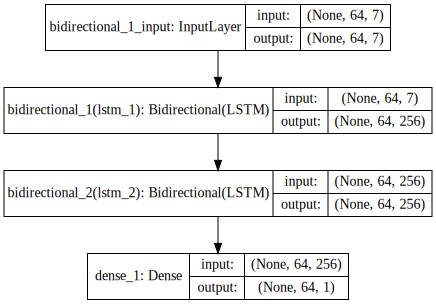

In [10]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(PREDICT_SIZE, 7)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=128, l2=128)

history = History()
model.fit(train_x, train_y, epochs=10, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34300 samples, validate on 8575 samples
Epoch 1/10
68s - loss: 0.0162 - acc: 0.0000e+00 - r2: -5.7514e-01 - val_loss: 0.0120 - val_acc: 1.1662e-04 - val_r2: -2.3512e-01
Epoch 2/10
65s - loss: 0.0104 - acc: 0.0000e+00 - r2: -2.6228e-03 - val_loss: 0.0117 - val_acc: 1.1662e-04 - val_r2: -2.9702e-01
Epoch 3/10
65s - loss: 0.0102 - acc: 0.0000e+00 - r2: 0.0157 - val_loss: 0.0115 - val_acc: 1.1662e-04 - val_r2: -2.7930e-01
Epoch 4/10
66s - loss: 0.0101 - acc: 0.0000e+00 - r2: 0.0242 - val_loss: 0.0114 - val_acc: 1.1662e-04 - val_r2: -2.9177e-01
Epoch 5/10
65s - loss: 0.0100 - acc: 0.0000e+00 - r2: 0.0319 - val_loss: 0.0115 - val_acc: 1.1662e-04 - val_r2: -3.8397e-01
Epoch 6/10


In [ ]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

In [ ]:
vis_evaluate(model, test_x, test_y)